## Question: How does Zipf's Exponent change with sample size?

Our entire thesis is that Zipf's Law and Heap's Law are (excellent) approximations for describing text, but ultimately wrong. Let's face it, if they're wrong, it's not by much. So, if these polylogarithmic functions are correct, then what's the "apparent" Zipf exponent $\alpha(x)$, and is there a compelling derivation that matches the empirical curve?

In [2]:
# bloody dependencies
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 16,8
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, LogModel

In [3]:
def zetainv(h):
    func = lambda z: zeta(z) - h
    z0 = 1.1
    z = fsolve(func, z0)[0]
    return z

def hapax(x):
    if abs(x-1) < 0.001:
        return 0.5
    return 1./np.log(x) - 1./(x-1)

### Choosing a Book

Select a book for use as our fitting corpus.

Optimum (M_z,N_z) = LogParams(M_z=173158, N_z=15848)


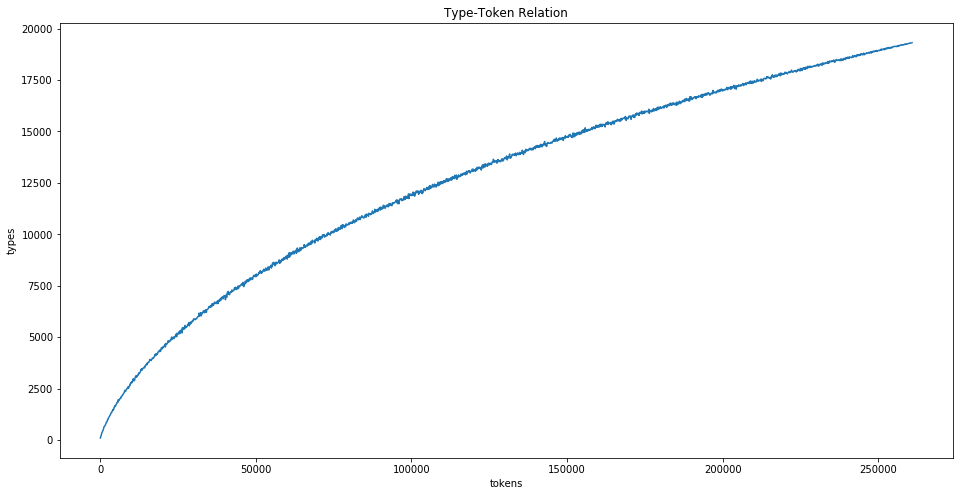

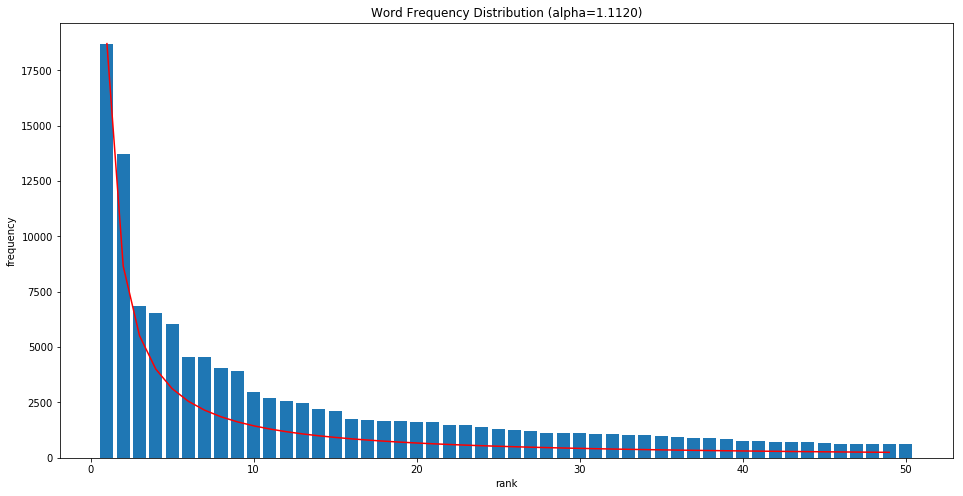

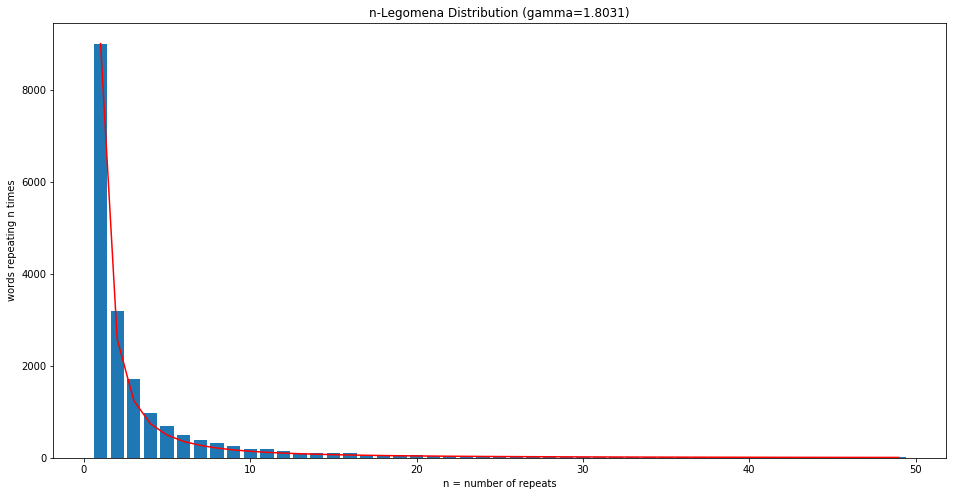

In [4]:
# moby dick
words = gutenberg.words("melville-moby_dick.txt")
corpus = Corpus(words)
corpus.resolution = 2000
corpus.dimension = 20
TTR = corpus.TTR
model = LogModel().fit(TTR.m_tokens, TTR.n_types)
print("Optimum (M_z,N_z) =", model.params)

# plot TTR curve
plt.plot(TTR.m_tokens, TTR.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.show()

# plot WFD
xmax = 50
i = np.arange(1, xmax)
df = corpus.fdist.head(xmax)
alpha = corpus.alpha
plt.bar(df.index, df.freq)
plt.plot(i, corpus.fdist.freq[1]/i**alpha, color = 'r')
plt.title("Word Frequency Distribution (alpha=%0.4f)" % alpha)
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
gamma = corpus.gamma
plt.bar(i, corpus.k[i])
plt.plot(i, corpus.k[1]/i**gamma, color = 'r')
plt.title("n-Legomena Distribution (gamma=%0.4f)" % gamma)
plt.xlabel("n = number of repeats")
plt.ylabel("words repeating n times")
plt.show()

### How do alpha & gamma vary over sample size?

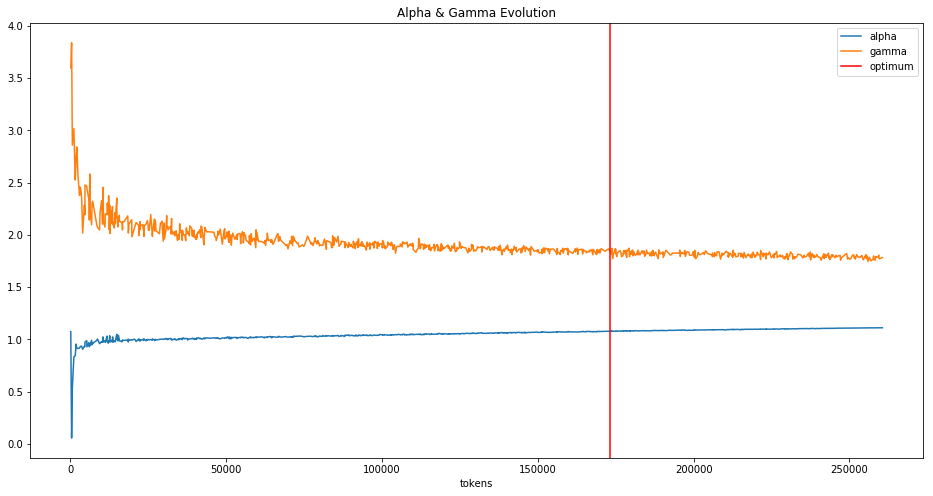

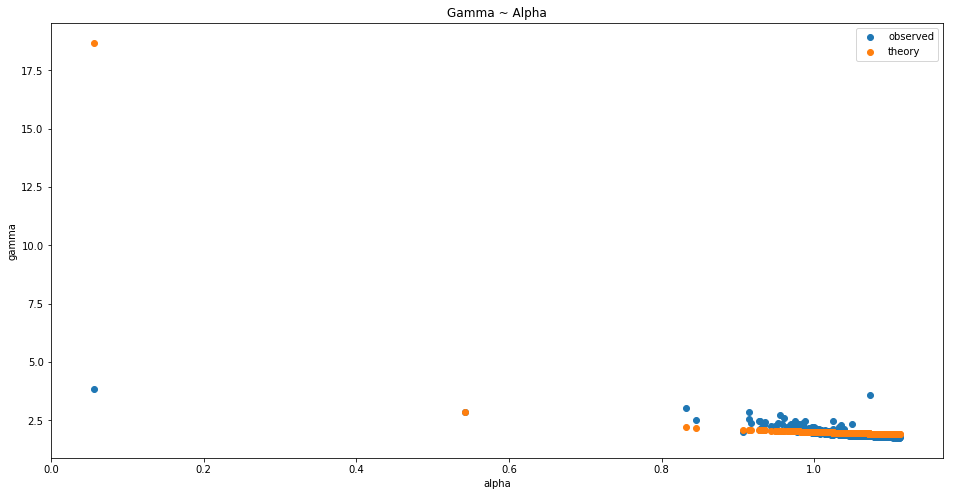

In [5]:
# get data
data = []
for _ in range(999):
    m_tokens = np.random.choice(range(corpus.M))
    minicorpus = corpus.sample(m_tokens)
    alpha, gamma = minicorpus.alpha, minicorpus.gamma
    data.append((m_tokens, alpha, gamma))
data = pd.DataFrame(data, columns = ["m_tokens", "alpha", "gamma"]).sort_values("m_tokens")

# plot it!
plt.plot(data.m_tokens, data.alpha, label="alpha")
plt.plot(data.m_tokens, data.gamma, label="gamma")
plt.axvline(x = model.M_z, color = 'r', label = "optimum")
plt.title("Alpha & Gamma Evolution")
plt.xlabel("tokens")
plt.legend()
plt.show()

# gamma ~ alpha relationship
plt.scatter(data.alpha, data.gamma, label="observed")
plt.scatter(data.alpha, 1 + 1/data.alpha, label="theory")
plt.title("Gamma ~ Alpha")
plt.xlabel("alpha")
plt.ylabel("gamma")
plt.legend()
plt.show()

## What do Alpha & Gamma look like at the optimum sample size?

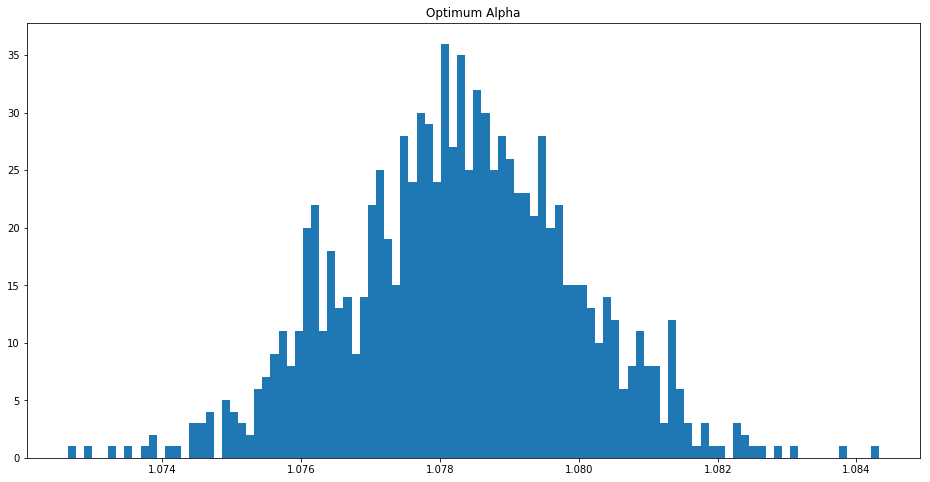

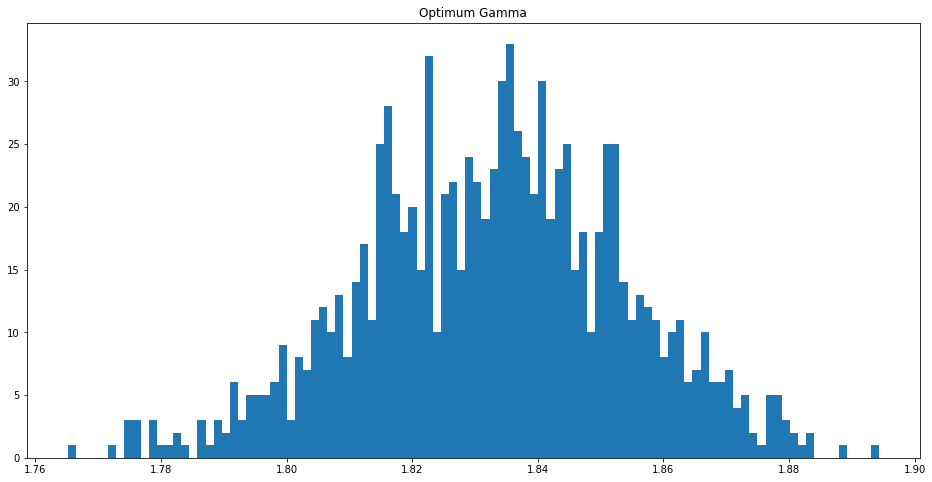

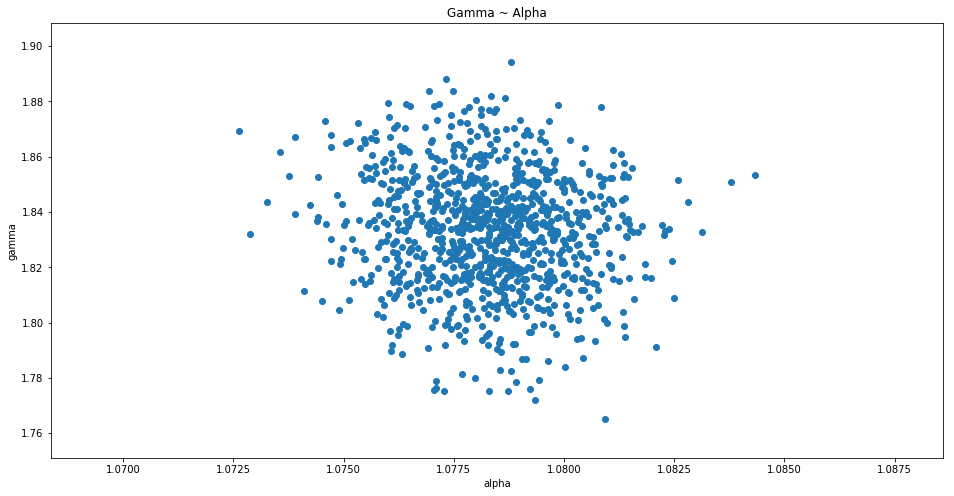

In [6]:
# get data
data = []
for _ in range(999):
    optimum = corpus.sample(model.M_z)
    alpha, gamma = optimum.alpha, optimum.gamma
    data.append((alpha, gamma))
data = pd.DataFrame(data, columns = ["alpha", "gamma"])

# alpha
plt.hist(data.alpha, bins=100)
plt.title("Optimum Alpha")
plt.show()

# gamma
plt.hist(data.gamma, bins=100)
plt.title("Optimum Gamma")
plt.show()

# gamma ~ alpha relationship
plt.scatter(data.alpha, data.gamma)
plt.title("Gamma ~ Alpha")
plt.xlabel("alpha")
plt.ylabel("gamma")
plt.show()

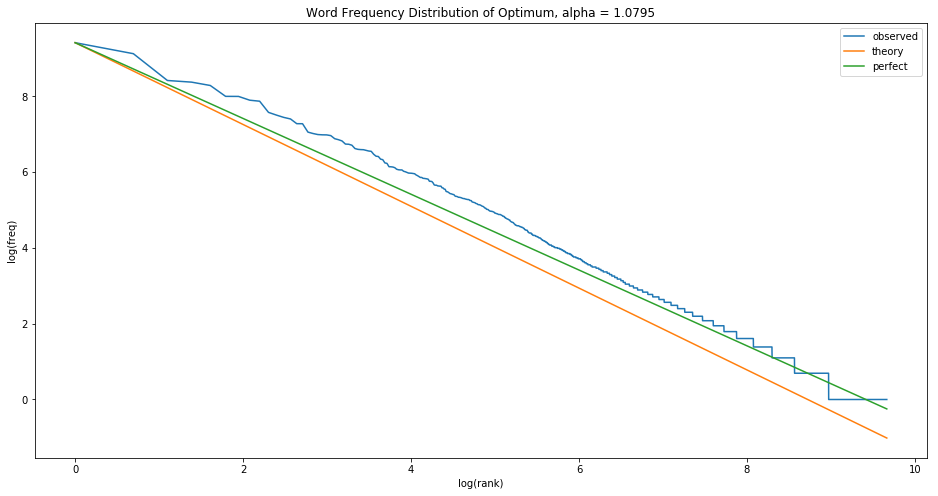

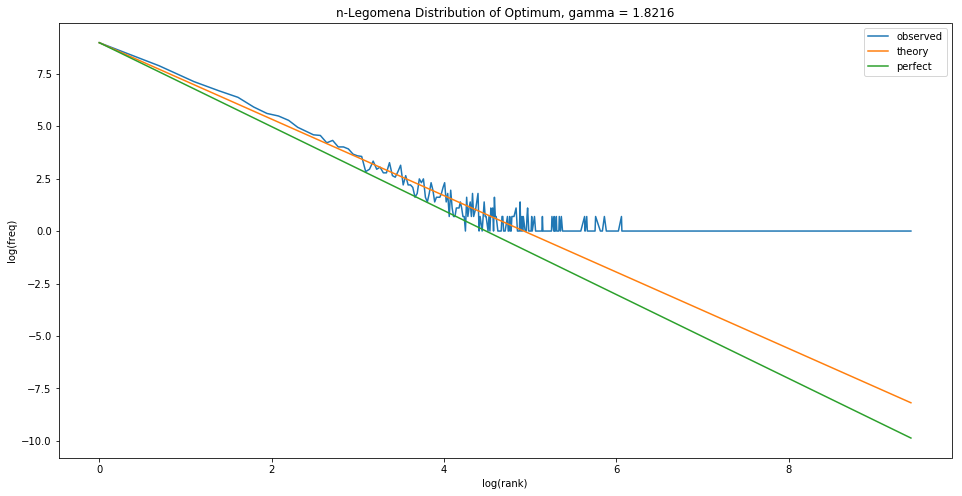

In [7]:
# word-frequency distribution
alpha = optimum.alpha
df = optimum.fdist
logrank = np.log(df.index.values)
logfreq = np.log(df.freq.values)
plt.plot(logrank, logfreq, label="observed")
plt.plot(logrank, max(logfreq) -alpha * logrank, label="theory")
plt.plot(logrank, max(logfreq) -1 * logrank, label="perfect")
plt.title("Word Frequency Distribution of Optimum, alpha = %0.4f" % alpha)
plt.xlabel("log(rank)") 
plt.ylabel("log(freq)")
plt.legend()
plt.show()

# n-legomena distribution
gamma = optimum.gamma
df = optimum.kdf
df.head()
logrank = np.log(df.index.values)
logfreq = np.log(df.freq.values)
plt.plot(logrank, logfreq, label="observed")
plt.plot(logrank, max(logfreq) -gamma * logrank, label="theory")
plt.plot(logrank, max(logfreq) -2 * logrank, label="perfect")
plt.title("n-Legomena Distribution of Optimum, gamma = %0.4f" % gamma)
plt.xlabel("log(rank)")
plt.ylabel("log(freq)")
plt.legend()
plt.show()

curve_fit= -1.656583275022922
linregress = -1.8215845983006493
clauset= -1.5797401733704617


Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


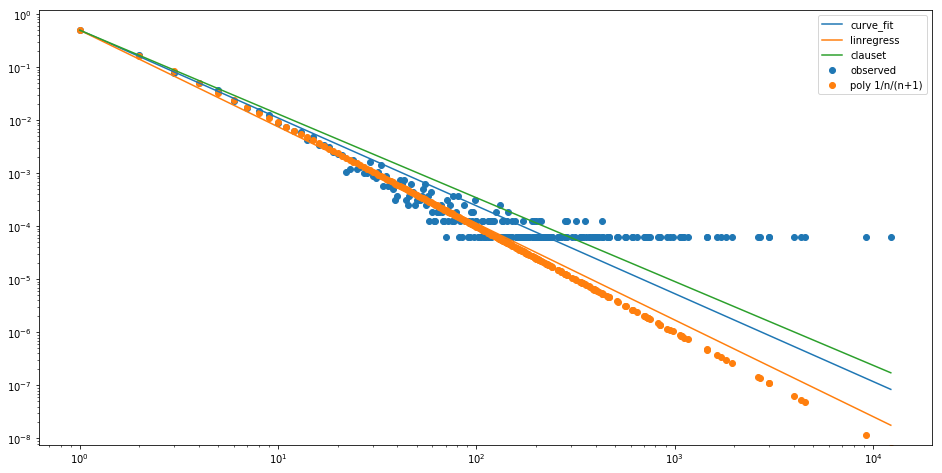

,freq,norm,poly,curve_fit,linregress,clauset
1,7892,0.500158,0.500000,0.501692,0.500158,0.500158
2,2633,0.166867,0.166667,0.159131,0.141500,0.167324
3,1235,0.078269,0.083333,0.081292,0.067607,0.088182
4,800,0.050700,0.050000,0.050475,0.040032,0.055977
5,584,0.037011,0.033333,0.034877,0.026661,0.039347


,freq,norm,poly,curve_fit,linregress,clauset
3975,1,0.000063,6.327272e-08,5.468086e-07,1.388707e-07,1.030600e-06
4343,1,0.000063,5.300543e-08,4.722101e-07,1.181859e-07,8.960760e-07
4536,1,0.000063,4.859126e-08,4.393935e-07,1.091863e-07,8.365931e-07
9203,1,0.000063,1.180576e-08,1.360999e-07,3.009365e-08,2.736082e-07
12303,1,0.000063,6.606062e-09,8.413819e-08,1.773399e-08,1.729629e-07


In [8]:
# manual
df = optimum.kdf
x = df.index.values
df["norm"] = df.freq / df.freq.sum()
df["poly"] = 1.0 / x / (x+1)
df.head()

y = df.norm.values

# method 1: curve_fit
def func_powerlaw(x, a, b):
    return a * x**b
from scipy.optimize import curve_fit
[a,b], _ = curve_fit(func_powerlaw, x, y)
curve_fit_ = func_powerlaw(x, a, b)
df["curve_fit"] = curve_fit_
print("curve_fit=", b)

# method 2: log linear regression
alpha = corpus._powerlaw(x, y)
print("linregress =", alpha)
linregress_ = y[0] * x**alpha
df["linregress"] = linregress_

# method 3: clauset
import powerlaw
dist = powerlaw.Fit(y).power_law
alpha = dist.alpha
print("clauset=", -alpha)
clauset_ = y[0] * x**-alpha
df["clauset"] = clauset_

# pretty picture
plt.scatter(x, y, label="observed")
plt.scatter(x, df["poly"], label="poly 1/n/(n+1)")
plt.loglog(x, curve_fit_, label="curve_fit")
plt.loglog(x, linregress_, label="linregress")
plt.loglog(x, clauset_, label="clauset")
plt.legend()
plt.show()

# table
display(df.head())
display(df.tail())

,m_tokens,n_types,alpha,gamma,lego_0,lego_1,lego_2,lego_3,lego_4,lego_5,...,lego_15_p_obs,lego_15_p_exp,lego_16_p_obs,lego_16_p_exp,lego_17_p_obs,lego_17_p_exp,lego_18_p_obs,lego_18_p_exp,lego_19_p_obs,lego_19_p_exp
0,130,94,0.652077,3.532495,19223,81,7,1,1,2,...,NaN,0.000137,NaN,0.000111,NaN,0.000091,NaN,0.000076,NaN,0.000064
1,260,170,0.371969,3.837943,19147,143,10,8,4,1,...,0.0,0.000190,0.000000,0.000156,0.005882,0.000129,0.000000,0.000108,0.000000,0.000092
2,391,222,0.334419,2.911201,19095,174,25,7,3,1,...,0.0,0.000230,0.000000,0.000189,0.000000,0.000157,0.000000,0.000132,0.000000,0.000112
3,521,315,0.854135,3.100689,19002,263,26,9,3,3,...,0.0,0.000251,0.003175,0.000207,0.000000,0.000173,0.000000,0.000145,0.000000,0.000124
4,652,358,0.713696,2.934260,18959,290,31,12,5,3,...,0.0,0.000273,0.000000,0.000225,0.002793,0.000188,0.002793,0.000159,0.005587,0.000135


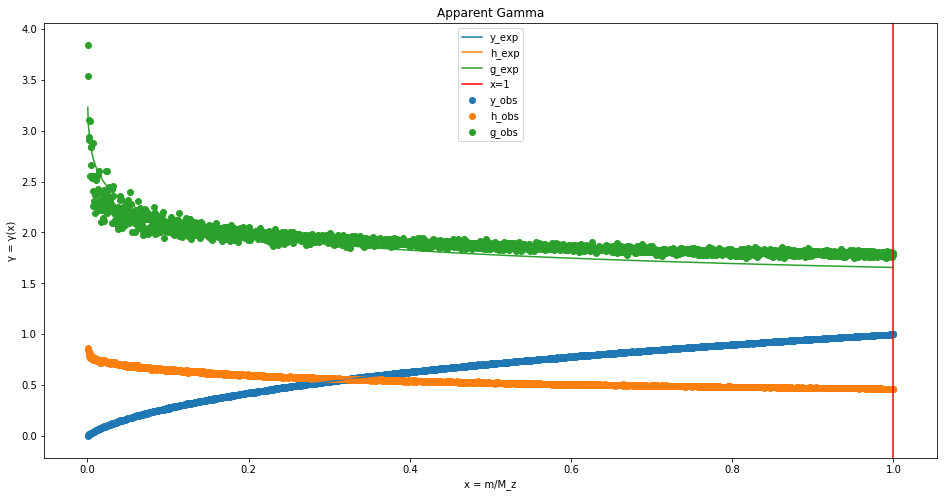

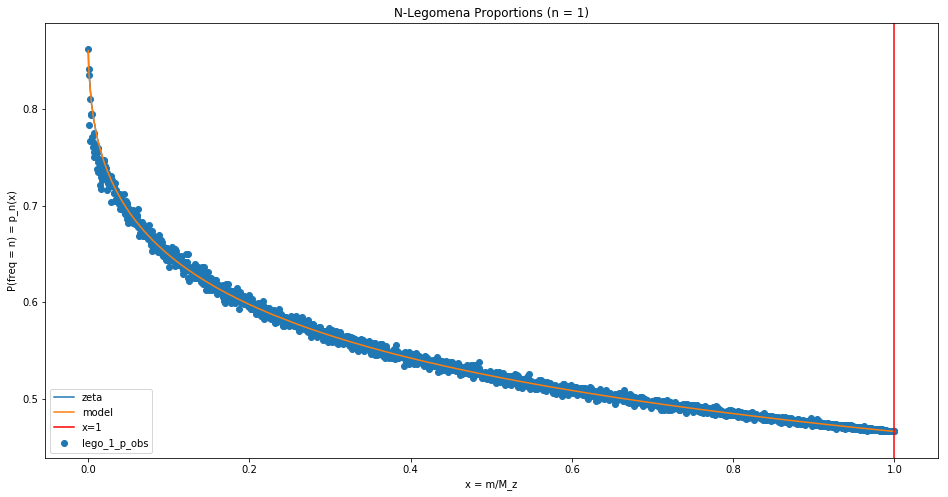

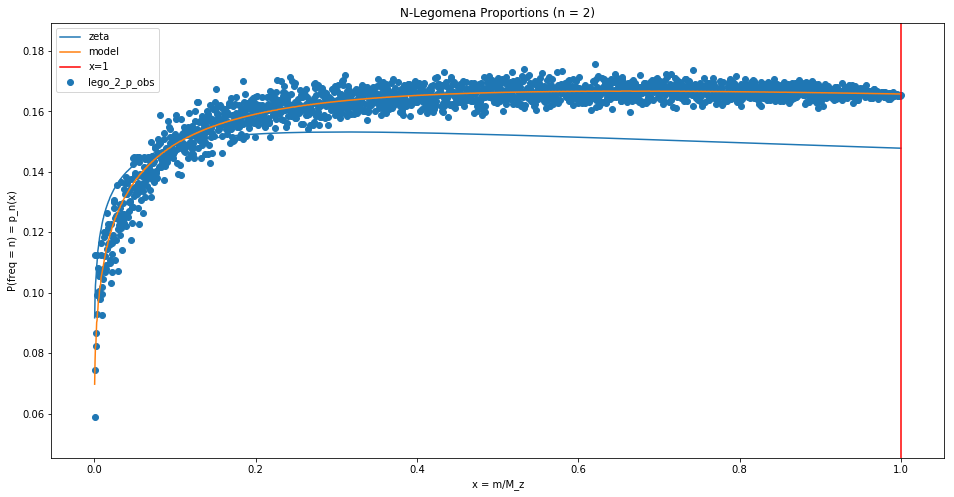

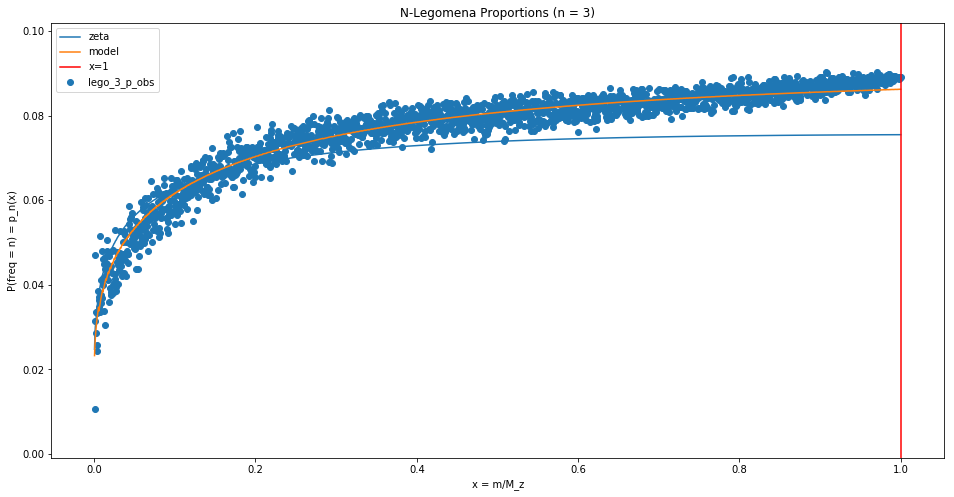

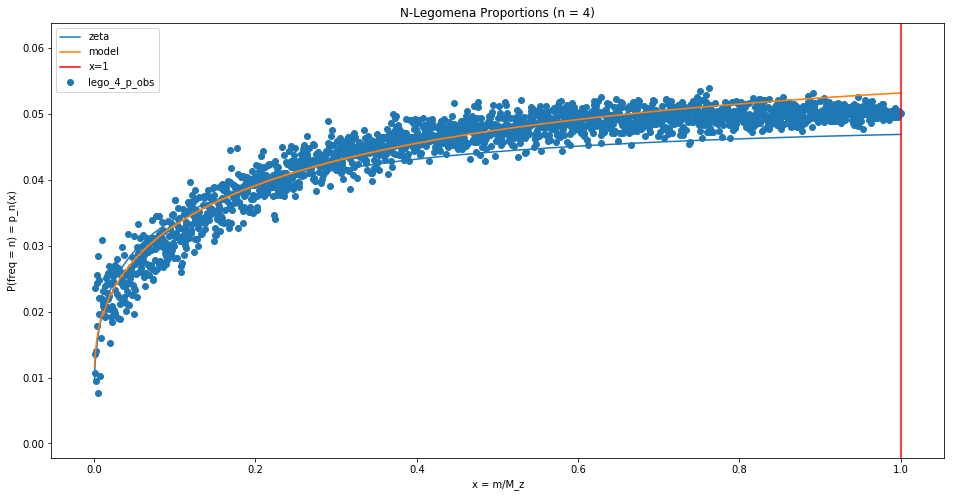

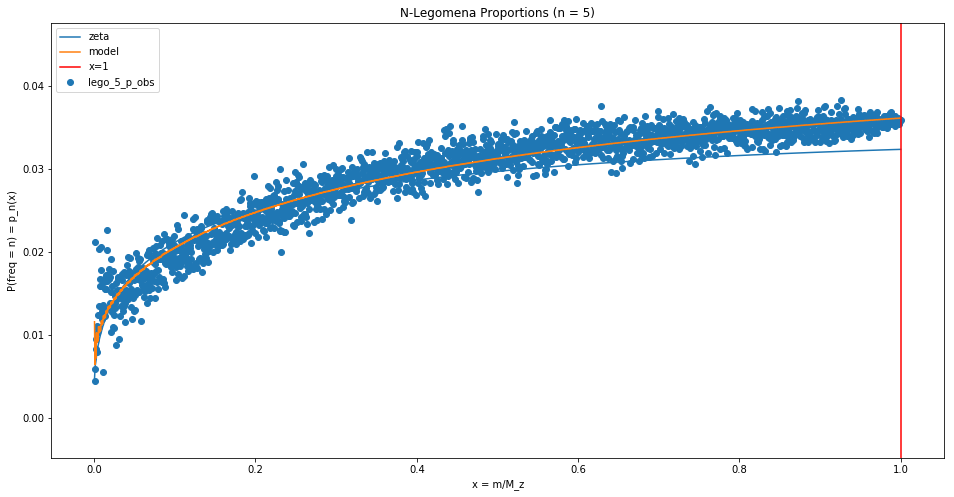

In [9]:
# calculate apparent gamma
TTR = corpus.TTR
k_x = model.predict_k(TTR.m_tokens, corpus.dimension)
E_x = model.predict(TTR.m_tokens)

# enrich TTR data
df = TTR
df["x"] = df.m_tokens / corpus.M
df["y_obs"] = df.n_types / corpus.N
df["y_exp"] = E_x / corpus.N
df["h_obs"] = df.lego_1 / df.n_types
df["h_exp"] = k_x[:,1] / E_x
df["g_exp"] = [ zetainv(1/h) for h in df["h_exp"] ]

for col in df.columns:
    if "lego_" in col:
        n = float(col.split("_")[1])
        df[col + "_p_obs"] = df[col] / df.n_types
        df[col + "_p_exp"] = df["h_exp"] / n**df["g_exp"]
        if n < 6:
            df[col + "_p_mod"] = k_x[:,int(n)] / E_x
display(df.head())

# draw a pretty plot
plt.plot(df["x"], df["y_exp"], label = "y_exp")
plt.plot(df["x"], df["h_exp"], label = "h_exp")
plt.plot(df["x"], df["g_exp"], label = "g_exp")
plt.scatter(df["x"], df["y_obs"], label = "y_obs")
plt.scatter(df["x"], df["h_obs"], label = "h_obs")
plt.scatter(df["x"], df["gamma"], label = "g_obs")
plt.axvline(x = 1, color = 'r', label = "x=1")
plt.xlabel("x = m/M_z")
plt.ylabel("γ = γ(x)")
plt.legend()
plt.title("Apparent Gamma")
plt.show()

# draw more pretty plots
for n in range(1, 6):
    plt.scatter(df["x"], df[f"lego_{n}_p_obs"], label = f"lego_{n}_p_obs")
    plt.plot(df["x"], df[f"lego_{n}_p_exp"], label = "zeta")
    plt.plot(df["x"], df[f"lego_{n}_p_mod"], label = "model")
    plt.axvline(x = 1, color = 'r', label = "x=1")
    plt.xlabel("x = m/M_z")
    plt.ylabel("P(freq = n) = p_n(x)")
    plt.legend()
    plt.title(f"N-Legomena Proportions (n = {n})")
    plt.show()

## Conclusion

Sadly, I can't seem to square this concept. Although the $n$-legomena proportions appear to converge on a Zeta Distribution in the limit, taking this idea literally does not appear to bear fruit. Look no further than the dis legomena prediction at $x=1$. Our model predicts $p_2(1) = 1/6 \approx 0.1667$ which is far closer to empirical observations than a Zeta Distribution, in which $p_2(1) = p_1(1) / 2^{\zeta^{-1}(1/p_1(1))} \approx 0.5/2^{1.72864723899818} \approx 0.15086737$.

Having said that, the curves really do _look_ and _behave_ somewhat the same, even though they clearly aren't _equal_. So it's conceivable there is some deeper connection between the two or some conversion factor buried in the math linking the polylogarithms to a simple exponent. Seems like an outside chance, but it can't be ruled out that some modification to a Zeta Distribution may fit the data.